<a href="https://colab.research.google.com/github/Vinooj/health-kiosk/blob/main/notebooks/fine_tune_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fintuning SigLIP with SCIN dataset

### Get access to SigLIP

Before you get started, make sure that you have access to MedSigLIP models on
Hugging Face:

1.  If you don't already have a Hugging Face account, you can create one for
    free by clicking [here](https://huggingface.co/join).
2.  Head over to the
    [SigLIP model page](https://huggingface.co/google/siglip-base-patch16-224) and
    accept the usage conditions.

### Install dependencies

In [48]:
! pip install --upgrade --quiet accelerate datasets evaluate tensorboard transformers peft

## Prepare fine-tuning dataset

This notebook uses the
[SCIN dataset](https://github.com/google-research-datasets/scin) to fine-tune MedSigLIP to classify the ten most common dermatology conditions:

```
["Eczema", "Allergic Contact Dermatitis", "Insect Bite", "Urticaria", "Psoriasis", "Folliculitis", "Irritant Contact Dermatitis", "Tinea", "Herpes Zoster", "Drug Rash"]
```

**Note:** The SCIN dataset was included in MedSigLIP's training data. It is used as a fine-tuning dataset in this notebook for demonstration purposes.

Download the dataset from
[Cloud Storage](https://console.cloud.google.com/storage/browser/dx-scin-public-data).

In [3]:
# Skip authentication since this dataset is public
! gcloud config set auth/disable_credentials True && gcloud config set user_output_enabled False

! mkdir dataset
! gcloud storage cp -R gs://dx-scin-public-data/dataset/* dataset/

Updated property [auth/disable_credentials].
Updated property [core/user_output_enabled].


In [ ]:
import os

# Create sample_data directory if it doesn't exist
# if not os.path.exists('sample_data'):
#     os.makedirs('sample_data')

# # Zip the dataset folder
# ! zip -r dataset.zip dataset/

# # Move the zipped file to sample_data
# ! mv dataset.zip sample_data/

Load the dataset as a `pandas.DataFrame`.

In [5]:
import pandas as pd

SCIN_GCS_CASES_CSV = "dataset/scin_cases.csv"
SCIN_GCS_LABELS_CSV = "dataset/scin_labels.csv"


def initialize_df_with_metadata(csv_path: str):
    df = pd.read_csv(csv_path, dtype={"case_id": str})
    df["case_id"] = df["case_id"].astype(str)
    return df


def augment_metadata_with_labels(df: pd.DataFrame, csv_path: str):
    labels_df = pd.read_csv(csv_path, dtype={"case_id": str})
    print(f"Loaded labels with {len(labels_df)} rows.")
    labels_df["case_id"] = labels_df["case_id"].astype(str)
    merged_df = pd.merge(df, labels_df, on="case_id")
    return merged_df


scin_no_label_df = initialize_df_with_metadata(SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, SCIN_GCS_LABELS_CSV)
scin_df.set_index("case_id", inplace=True)

scin_df

Loaded labels with 5033 rows.


,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
case_id,,,,,,,,,,,,,,,,,,,,,
-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973759811984683137,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,NaN,NaN,NaN,NaN,...,YES,YES,YES,FST2,FST2,FST3,True,True,4.0,4.0
973872028150293734,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,1.0
983265958160210646,SCIN,1.0.0,2023,AGE_18_TO_29,FEMALE,FST5,NaN,NaN,YES,NaN,...,YES,NaN,NaN,FST5,NaN,NaN,True,True,4.0,5.0


Process the DataFrame so that each row corresponds to a training example with an `image` and `label`.

Filter examples with insufficient image quality and
low-confidence labels. Additionally, in the original dataset each data donator contributes up to three images. Make each individual image and its corresponding label into separate examples in the resulting training dataset.

1. **Decision Criteria for Selecting 10 Conditions:** The notebook deliberately focuses on the ***ten most common dermatology conditions*** from the SCIN dataset (Based on Domain knowledge and dataset). This strategic choice allows the model to become highly specialized and potentially more accurate in distinguishing these specific, high-frequency conditions, rather than attempting to classify a much broader and more complex range of dermatological issues.

2. **Impact on Accuracy:** This focused approach leads to potentially **higher accuracy for the selected 10 conditions** themselves. However, it also means the model has a **limited scope of prediction**. It can only classify among these 10. If an image contains a condition outside this list, the model won't be able to identify it correctly; it will either misclassify it as one of the 10 or indicate low confidence across all known categories.

3. **Handling Images Not Falling into These Categories (Elimination/Filtering):** The process of handling labels not in the 10 conditions is managed during the dataset preprocessing, specifically in cell zJA08zNDLQtR:

    - The remove_low_confidence_labels function plays a key role. It iterates through the original labels for each case and **only retains labels that are explicitly present in the predefined CONDITIONS list**. Any original label not found within these 10 conditions is effectively filtered out and ignored.
    - Following this, the MultiLabelBinarizer converts these filtered (and now limited to the 10 conditions) labels into a one-hot encoded vector. This ensures that the model only sees and trains on information relevant to the 10 chosen classes, effectively eliminating extraneous information from other conditions present in the raw data.

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

CONDITIONS = ["Eczema", "Allergic Contact Dermatitis", "Insect Bite", "Urticaria", "Psoriasis", "Folliculitis", "Irritant Contact Dermatitis", "Tinea", "Herpes Zoster", "Drug Rash"]
MINIMUM_CONFIDENCE = 0


def remove_low_confidence_labels(row: pd.Series):
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidences = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidences):
        if label in CONDITIONS and confidence >= MINIMUM_CONFIDENCE:
            row_labels.append(label)
    return row_labels


# Filter examples with insufficient image quality
scin_df = scin_df[scin_df.dermatologist_gradable_for_skin_condition_1 == "DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT"]

# Remove labels that are below a minimum confidence
scin_df["label"] = scin_df.apply(remove_low_confidence_labels, axis=1)

# Make each image (if it exists) into a separate example.
# Also create a new dataframe with only images and labels.
image_cols = ["image_1_path", "image_2_path", "image_3_path"]
scin_df = pd.melt(
    scin_df, id_vars=["label"], value_vars=image_cols, value_name="image"
).drop(columns=["variable"]).dropna(subset=["image"]).set_index("image")

# Convert labels from e.g. [["Eczema"], ["Urticaria", "Insect Bite"]] to
# [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]]
mlb = MultiLabelBinarizer(classes=CONDITIONS)
scin_df["label"] = mlb.fit_transform(scin_df["label"]).tolist()

# Drop missing image (https://github.com/google-research-datasets/scin/issues/1)
scin_df.drop(index=["dataset/images/-2243186711511406658.png"], inplace=True)

scin_df

/tmp/ipython-input-372976252.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scin_df["label"] = scin_df.apply(remove_low_confidence_labels, axis=1)


,label
image,
dataset/images/-3205742176803893704.png,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
dataset/images/-4762289084741430925.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
dataset/images/-4027806997035329030.png,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
dataset/images/-3799298995660217860.png,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
dataset/images/-3575683440831198879.png,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...
dataset/images/724924647087331057.png,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
dataset/images/7906315042206534866.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
dataset/images/8763368682344373991.png,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


Load the DataFrame as a Hugging Face `Dataset` with `from_pandas()`. Then, create train, validation, and test splits.

Initial scin_df after merging labels had 5033 rows (cases), but the number of samples in the dataset for training became 6451. This is because:

1. **Multiple Images per Case:** The original scin_df had image_1_path, image_2_path, and image_3_path columns. The code used pd.melt to transform this, creating a separate row for each image associated with a case. So, if a single case had 3 images, it became 3 separate image examples for the model.
2. **Filtering:** Some examples were filtered out due to insufficient image quality or missing images, which brought the total number of valid image examples down to 6451.

From these** 6451 total image samples**, the split was as follows:

- Initial Split (test_size=0.2):
  - Training Set: 80% of 6451 ≈ 5160 samples.
  - Temporary Test/Validation Pool: 20% of 6451 ≈ 1291 samples.
- Second Split (test_size=0.5) of the Temporary Pool:
  - Validation Set: 50% of 1291 = 645 samples.
  - Test Set: 50% of 1291 = 646 samples.

In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def initialize_df_with_metadata(csv_path: str):
    df = pd.read_csv(csv_path, dtype={"case_id": str})
    df["case_id"] = df["case_id"].astype(str)
    return df

def augment_metadata_with_labels(df: pd.DataFrame, csv_path: str):
    labels_df = pd.read_csv(csv_path, dtype={"case_id": str})
    labels_df["case_id"] = labels_df["case_id"].astype(str)
    merged_df = pd.merge(df, labels_df, on="case_id")
    return merged_df

# Step 1: Initial load of cases and labels
scin_no_label_df_temp = initialize_df_with_metadata(SCIN_GCS_CASES_CSV)
scin_df_temp = augment_metadata_with_labels(scin_no_label_df_temp, SCIN_GCS_LABELS_CSV)
scin_df_temp.set_index("case_id", inplace=True)
print(f"Initial number of cases (rows) after merging labels: {len(scin_df_temp)}")

# Step 2: Filter examples with insufficient image quality
original_cases_count = len(scin_df_temp)
scin_df_temp = scin_df_temp[scin_df_temp.dermatologist_gradable_for_skin_condition_1 == "DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT"]
filtered_cases_count = len(scin_df_temp)
print(f"Number of cases (rows) after filtering for image quality: {filtered_cases_count}")
print(f"Number of cases filtered out by image quality: {original_cases_count - filtered_cases_count}")

# Step 3: Remove low confidence labels and melt to individual image examples
CONDITIONS = ["Eczema", "Allergic Contact Dermatitis", "Insect Bite", "Urticaria", "Psoriasis", "Folliculitis", "Irritant Contact Dermatitis", "Tinea", "Herpes Zoster", "Drug Rash"]
MINIMUM_CONFIDENCE = 0

def remove_low_confidence_labels(row: pd.Series):
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidences = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidences):
        if label in CONDITIONS and confidence >= MINIMUM_CONFIDENCE:
            row_labels.append(label)
    return row_labels

scin_df_temp["label"] = scin_df_temp.apply(remove_low_confidence_labels, axis=1)

image_cols = ["image_1_path", "image_2_path", "image_3_path"]
initial_image_rows_after_melt = len(pd.melt(scin_df_temp, id_vars=["label"], value_vars=image_cols, value_name="image").drop(columns=["variable"]))

scin_df_temp = pd.melt(
    scin_df_temp, id_vars=["label"], value_vars=image_cols, value_name="image"
).drop(columns=["variable"])

# Count rows after melt, before dropna
print(f"Number of image rows after melting (before dropping NaN images): {len(scin_df_temp)}")

scin_df_temp_before_dropna = len(scin_df_temp)
scin_df_temp = scin_df_temp.dropna(subset=["image"])
print(f"Number of image rows after dropping NaN images: {len(scin_df_temp)}")
print(f"Number of image rows filtered out by dropping NaN images: {scin_df_temp_before_dropna - len(scin_df_temp)}")

# Step 4: Drop specific missing image
scin_df_temp_before_specific_drop = len(scin_df_temp)
# Check if the specific image path exists in the index before attempting to drop
if "dataset/images/-2243186711511406658.png" in scin_df_temp.set_index("image").index:
    scin_df_temp = scin_df_temp.set_index("image").drop(index=["dataset/images/-2243186711511406658.png"], errors='ignore')
    # Reset index if it was set for the drop operation
    if isinstance(scin_df_temp, pd.DataFrame):
        scin_df_temp = scin_df_temp.reset_index()
else:
    print("Specific missing image 'dataset/images/-2243186711511406658.png' not found in DataFrame for explicit drop.")

print(f"Final number of image rows before `from datasets import Dataset`: {len(scin_df_temp)}")
print(f"Number of image rows filtered out by specific image drop: {scin_df_temp_before_specific_drop - len(scin_df_temp)}")

Initial number of cases (rows) after merging labels: 5033
Number of cases (rows) after filtering for image quality: 3049
Number of cases filtered out by image quality: 1984
Number of image rows after melting (before dropping NaN images): 9147
Number of image rows after dropping NaN images: 6452
Number of image rows filtered out by dropping NaN images: 2695
Final number of image rows before `from datasets import Dataset`: 6451
Number of image rows filtered out by specific image drop: 1


In [8]:
from datasets import Dataset, Image

data = Dataset.from_pandas(scin_df)
# Decode image paths as PIL images
data = data.cast_column("image", Image())
data = data.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42,
)
validation_test_data = data.pop("test").train_test_split(
    test_size=0.5,
    shuffle=True,
    seed=42,
)
data["validation"] = validation_test_data["train"]
data["test"] = validation_test_data["test"]

# Display dataset details
data

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 5160
    })
    validation: Dataset({
        features: ['label', 'image'],
        num_rows: 645
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 646
    })
})

Inspect a sample data point, which contains:

* `image`: dermatology image as a `PIL` image object
* `label`: corresponding multiple labels as a one-hot encoded vector

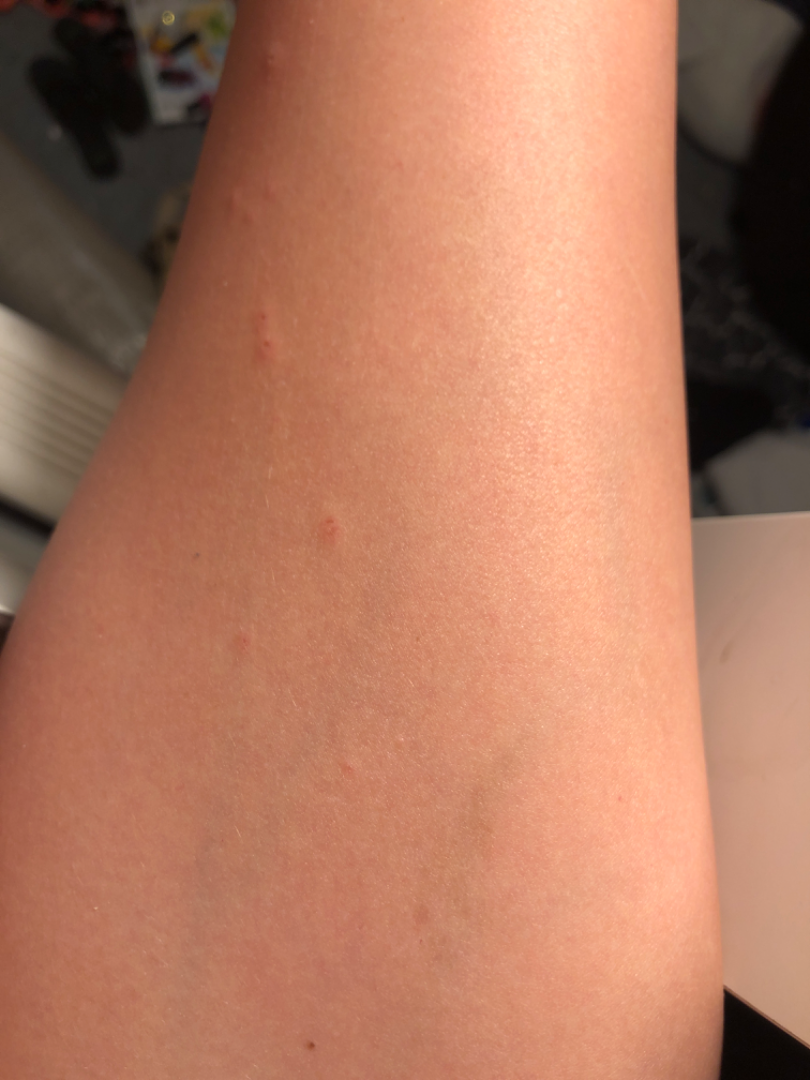

In [9]:
data["train"][1]["image"]

In [10]:
data["train"][1]["label"]

[0, 1, 1, 1, 0, 0, 0, 0, 0, 0]

Preprocess the input images.

The model expects the input images to be resized to 448x448 with pixel values rescaled to the range [-1, 1].

Note that the input images are also zero-padded to square before resizing to preserve aspect ratio. This step is included for consistency with the original MedSigLIP training data preprocessing.

In [12]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize, InterpolationMode
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/siglip-base-patch16-224")

size = image_processor.size["height"]  # 448
mean = image_processor.image_mean  # 0.5
std = image_processor.image_std  # 0.5

_transform = Compose([
    Resize((size, size), interpolation=InterpolationMode.BILINEAR),
    # Convert PIL image to PyTorch tensor and rescale pixel values from the
    # range [0, 255] to [0, 1]
    ToTensor(),
    # Scale pixel values to the range [-1, 1]
    Normalize(mean=mean, std=std),
])


def preprocess(examples):
    examples["pixel_values"] = [
        # CenterCrop effectively zero pads the image to a square with size equal
        # to the larger dimension
        _transform(CenterCrop(max(image.size))(image.convert("RGB")))
        for image in examples["image"]
    ]
    return examples


train_data = data["train"].map(preprocess, batched=True, remove_columns=["image"])
validation_data = data["validation"].map(preprocess, batched=True, remove_columns=["image"])

Map:   0%|          | 0/5160 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

## Fine-tune the model

This notebook demonstrates fine-tuning the MedSigLIP vision encoder for a multi-label image classification task on image and structured label data using the `Trainer` from the Hugging Face `Transformers` library.

Load the MedSigLIP vision encoder with an image classification head on top.

In [13]:
from transformers import AutoModelForImageClassification

model_id = "google/siglip-base-patch16-224"

# Define the label mappings for the classification task
id2label = {i: label for i, label in enumerate(CONDITIONS)}
label2id = {label: i for i, label in enumerate(CONDITIONS)}

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(CONDITIONS),
    id2label=id2label,
    label2id=label2id,
)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define a data collator to prepare batches of training examples.

In [14]:
import torch


def collate_fn(examples):
    pixel_values = torch.tensor([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples], dtype=torch.float)
    return {"pixel_values": pixel_values, "labels": labels}

Define evaluation metrics to be computed during training. The function takes in an [`EvalPrediction`](https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction) which contains the model predictions (logits) and labels.

Similar to MedSigLIP's reported metrics, this example uses the macro-averaged One-vs-rest ROC AUC (Area Under the Receiver Operating Characteristic Curve) score to evaluate multi-class classification performance. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for more details.

In [15]:
import evaluate
import numpy as np

roc_auc_score = evaluate.load("roc_auc", "multilabel")


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def metrics_fn(eval_pred):
    logits, labels = eval_pred
    scores = sigmoid(logits)
    return roc_auc_score.compute(
        prediction_scores=scores,
        references=labels,
        average="macro",
        multi_class="ovr",
    )

Define a weighted loss function to address class imbalance within the dataset.

This is the [default loss](https://github.com/huggingface/transformers/blob/cd74917ffc3e8f84e4a886052c5ab32b7ac623cc/src/transformers/models/siglip/modeling_siglip.py#L1205) used for multi-label classification but utilizes `pos_weight` to assign a per-class weight to positive examples, effectively treating minority positive classes with greater importance in the loss calculation. Refer to the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) for more details.

**Note:** There are other balancing methods such as oversampling that may be used depending on your dataset and classification task.

In [16]:
from torch.nn import BCEWithLogitsLoss

labels = torch.tensor(train_data["label"])
num_samples = labels.shape[0]
num_positive = labels.sum(axis=0)
num_negative = num_samples - num_positive
POS_WEIGHT = num_negative / num_positive


def loss_fn(outputs, labels, num_items_in_batch):
    logits = outputs.get("logits")
    pos_weight = POS_WEIGHT.to(logits.device)
    loss_fct = BCEWithLogitsLoss(pos_weight=pos_weight)
    return loss_fct(logits, labels)

## Apply LoRA

In [53]:
from peft import LoraConfig, get_peft_model

print("Applying LoRA configuration...")

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"],
    lora_dropout=0.1,
    bias="none",
)

model_to_tune = get_peft_model(model, lora_config)
model = model_to_tune.to("cuda")

Applying LoRA configuration...


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Configure training parameters in
[`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [57]:
from transformers import TrainingArguments

num_train_epochs = 3  # @param {type: "number"}
learning_rate = 5e-5  # @param {type: "number"}

training_args = TrainingArguments(
    output_dir="siglip-224-scin-classification",  # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,               # Number of training epochs
    per_device_train_batch_size=8,                   # Batch size per device during training
    per_device_eval_batch_size=8,                    # Batch size per device during evaluation
    gradient_accumulation_steps=8,                   # Number of steps before performing a backward/update pass
    logging_steps=40,                                # Number of steps between logs
    save_strategy="epoch",                           # Save checkpoint every epoch
    eval_strategy="steps",                           # Evaluate every `eval_steps`
    eval_steps=40,                                   # Number of steps between evaluations
    learning_rate=learning_rate,                     # Learning rate
    weight_decay=0.01,                               # Weight decay to apply
    warmup_steps=5,                                  # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine",                      # Use cosine learning rate scheduler
    push_to_hub=False,                                # Push model to Hub
    report_to="tensorboard",                         # Report metrics to tensorboard
)

In [ ]:
from peft import LoraConfig, get_peft_model

print("Applying LoRA configuration...")

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"],
    lora_dropout=0.1,
    bias="none",
)

model_to_tune = get_peft_model(model, lora_config)
model = model_to_tune.to("cuda")

Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters, data collator, metrics function, and weighted loss function.

In [58]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    compute_metrics=metrics_fn,
    compute_loss_func=loss_fn,
)

Launch the fine-tuning process.

**Note:** This may take around 3 hours to run using the default configuration.

In [59]:
trainer.train()

Step,Training Loss,Validation Loss,Roc Auc
40,4.170400,1.081006,0.778568
80,3.919500,1.116997,0.778132
120,3.858600,1.141176,0.777687
160,4.010400,1.145642,0.777674
200,3.433600,1.157626,0.777562
240,4.247200,1.158177,0.777581


TrainOutput(global_step=243, training_loss=3.9478415579462247, metrics={'train_runtime': 1875.9248, 'train_samples_per_second': 8.252, 'train_steps_per_second': 0.13, 'total_flos': 1.3048674399903744e+18, 'train_loss': 3.9478415579462247, 'epoch': 3.0})

Save the final model to Hugging Face Hub.

In [60]:
# from huggingface_hub import HfApi
# from google.colab import userdata

# # Retrieve the token from Colab secrets
# hf_token = userdata.get('HF_WRITE_TOKEN') # Assuming you named your token 'HF_TOKEN'

trainer.save_model()
# trainer.push_to_hub()

You can use the link below to navigate to your model repository and click on the "Training metrics" tab to view training curves.

In [61]:
from huggingface_hub import HfApi
from google.colab import userdata

# Retrieve the token from Colab secrets
hf_token = userdata.get('HF_TOKEN') # Assuming you named your token 'HF_TOKEN'

api = HfApi(token=hf_token)
username = api.whoami()["name"]
print(f"https://huggingface.co/{username}/{training_args.output_dir}")

https://huggingface.co/vinooj/siglip-224-scin-classification


## Evaluate the fine-tuned model

### Set up for evaluation

Load the ROC AUC (Area Under the Receiver Operating Characteristic Curve) and additional accuracy metrics to evaluate the model's performance on the classification task.

You can use other accuracy metrics based on your use case and performance requirements.

In [62]:
from typing import Union

import evaluate
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

roc_auc_score = evaluate.load("roc_auc", "multilabel")

# Ground-truth labels
REFERENCES = data["test"]["label"]


def compute_metrics(
    prediction_scores: np.ndarray,
    threshold: float,
) -> dict[str, float]:
    metrics = {}
    metrics.update(roc_auc_score.compute(
        prediction_scores=prediction_scores,
        references=REFERENCES,
        average="macro",
        multi_class="ovr",
    ))
    predictions = (prediction_scores > threshold).astype(int)
    mcm = multilabel_confusion_matrix(
        y_true=REFERENCES,
        y_pred=predictions,
    )
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    metrics.update({
        "sensitivity": tp / (tp + fn),
        "specificity": tn / (tn + fp),
    })
    return metrics


def print_metrics(metrics: dict[str, Union[float, np.ndarray]]) -> None:
    print(f"Macro-averaged one-vs-rest ROC AUC: {metrics['roc_auc']:.2f}")
    for metric in ["sensitivity", "specificity"]:
        print(f"\n{metric.capitalize()}:")
        for i, condition in enumerate(CONDITIONS):
            print(f"{condition}: {metrics[metric][i]:.4f}")

### Compute metrics on the fine-tuned model

Load the fine-tuned model.

In [63]:
ft_model = AutoModelForImageClassification.from_pretrained(
    training_args.output_dir,
    problem_type="multi_label_classification",
    num_labels=len(CONDITIONS),
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
)

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Let's break down the line outputs = ft_model(**inputs) bold text when you have a batch of 64 images, using a simple analogy.

Imagine your ft_model is a highly specialized team of ten doctors, one for each of the dermatology conditions you are trying to classify (Eczema, Insect Bite, etc.).

inputs: This is like taking a stack of 64 patient folders. Each folder contains one image that has already been prepared and cleaned up (resized, normalized, etc.) so the doctors can understand it perfectly.

ft_model(**inputs): The ** before inputs is just a technical way of saying, "Hey, model! Here's this whole stack of 64 patient folders." Instead of handing them one by one, you give the entire stack to the doctor team at once.

How the doctors (model) process the batch: The team of doctors doesn't just look at one image, finish their diagnosis, and then move to the next. Instead, they efficiently look at all 64 images almost simultaneously. Each doctor (representing a specific condition) quickly scans all 64 images and forms an initial opinion about whether their condition is present in each image.

outputs: This is the collective report from all ten doctors for all 64 patients. It's a structured collection of their findings.

logits: Within that outputs report, logits are the raw initial suspicion scores from each doctor. For every one of the 64 images, and for every one of the ten conditions, each doctor provides a number. This number isn't yet a neat probability (like "80% chance of Eczema"). Instead, it's a raw, unscaled score that indicates how strongly that specific doctor suspects their condition is present in that specific image. A higher positive number means stronger suspicion, a negative number means less suspicion, and zero means neutral. These scores will later be converted into actual probabilities (0 to 1) using the sigmoid function, which is like turning the doctors' raw suspicions into a final percentage chance.

In [64]:
from PIL import Image
import torch

prediction_scores = []
for batch in data["test"].batch(batch_size=64):
    images = [Image.open(image["path"]) for image in batch["image"]]
    inputs = image_processor(images=images, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = ft_model(**inputs)

    logits = outputs.logits
    scores = torch.sigmoid(logits)
    prediction_scores.extend(scores)

prediction_scores = torch.stack(prediction_scores).cpu().numpy()

Batching examples:   0%|          | 0/646 [00:00<?, ? examples/s]

In [65]:
# Default threshold used to convert probability scores into class predictions.
# Note that optimal threshold selection is not demonstrated in this notebook.
threshold = 0.5

metrics = compute_metrics(prediction_scores, threshold)
print_metrics(metrics)

Macro-averaged one-vs-rest ROC AUC: 0.52

Sensitivity:
Eczema: 0.9637
Allergic Contact Dermatitis: 0.8824
Insect Bite: 1.0000
Urticaria: 0.8571
Psoriasis: 0.0000
Folliculitis: 0.0000
Irritant Contact Dermatitis: 0.4068
Tinea: 0.6735
Herpes Zoster: 0.1905
Drug Rash: 0.0500

Specificity:
Eczema: 0.0151
Allergic Contact Dermatitis: 0.1765
Insect Bite: 0.0161
Urticaria: 0.1323
Psoriasis: 1.0000
Folliculitis: 0.9525
Irritant Contact Dermatitis: 0.4514
Tinea: 0.4941
Herpes Zoster: 0.8512
Drug Rash: 0.9934


Compute metrics.

**Note:** This notebook demonstrates a sample training run and the metrics below have not been optimized. Further tuning will be needed to achieve desired performance.

In [34]:
# Default threshold used to convert probability scores into class predictions.
# Note that optimal threshold selection is not demonstrated in this notebook.
threshold = 0.5

metrics = compute_metrics(prediction_scores, threshold)
print_metrics(metrics)

Macro-averaged one-vs-rest ROC AUC: 0.78

Sensitivity:
Eczema: 0.6613
Allergic Contact Dermatitis: 0.6631
Insect Bite: 0.6932
Urticaria: 0.8163
Psoriasis: 0.5758
Folliculitis: 0.6491
Irritant Contact Dermatitis: 0.5424
Tinea: 0.4898
Herpes Zoster: 0.5714
Drug Rash: 0.5250

Specificity:
Eczema: 0.5628
Allergic Contact Dermatitis: 0.6449
Insect Bite: 0.8100
Urticaria: 0.8342
Psoriasis: 0.7914
Folliculitis: 0.8472
Irritant Contact Dermatitis: 0.7905
Tinea: 0.8861
Herpes Zoster: 0.9184
Drug Rash: 0.8845


## Run batch inference on the test dataset.

Followig Code will pick a random image from the training set, run it through the fine-tuned model, and then display the model's predicted probabilities, the conditions it identified (based on a 0.5 threshold), and the original ground-truth labels for that image.

--- Verification with Top 5 Predicted Conditions ---

In [67]:
import random
import torch
from PIL import Image

# Choose a random index from the training data
random_index = random.randint(0, len(train_data) - 1)

# Get the original image path and label from the raw data before preprocessing
original_data_point = data["train"][random_index]
original_image_path = original_data_point["image"]
original_label = original_data_point["label"]

# Preprocess the image for the model
image = original_image_path.convert("RGB") # Corrected line
inputs = image_processor(images=[image], return_tensors="pt").to("cuda")

# Get model predictions
with torch.no_grad():
    outputs = ft_model(**inputs)

logits = outputs.logits
probabilities = torch.sigmoid(logits).cpu().numpy().flatten()

# Define a threshold for identifying conditions (same as used for evaluation)
threshold = 0.5
identified_conditions_binary = (probabilities > threshold).astype(int)

print(f"--- Analysis for Random Image (Index: {random_index}) ---")
print(f"Image Path: {original_image_path}") # Changed print statement for clarity
print("\nOriginal Labels (Ground Truth):")
original_condition_names = []
for i, val in enumerate(original_label):
    if val == 1:
        original_condition_names.append(CONDITIONS[i])
        print(f"- {CONDITIONS[i]}")

print("\nModel Predicted Probabilities and Identified Conditions (Threshold=0.5) (Sorted by Probability):")

# Combine probabilities, condition names, and identified status
prediction_details = []
for i, prob in enumerate(probabilities):
    condition_name = CONDITIONS[i]
    is_identified = bool(identified_conditions_binary[i])
    prediction_details.append((prob, condition_name, is_identified))

# Sort by probability in descending order
prediction_details.sort(key=lambda x: x[0], reverse=True)

identified_conditions_list = []
for prob, condition_name, is_identified in prediction_details:
    print(f"- {condition_name}: {prob:.4f} (Identified: {is_identified})")
    if is_identified:
        identified_conditions_list.append(condition_name)

if not identified_conditions_list:
    print("  No conditions identified by the model for this image.")
else:
    print(f"\nModel identified the following conditions: {', '.join(identified_conditions_list)}")

# --- Additional Verification: Check for intersection with top 5 predicted ---
print("\n--- Verification with Top 5 Predicted Conditions ---")

top_5_predicted_conditions = [detail[1] for detail in prediction_details[:5]]

## Run batch inference on the test dataset.

print(f"Top 5 Model Predicted Conditions: {', '.join(top_5_predicted_conditions)}")
print(f"Original Labels: {', '.join(original_condition_names)}")

# Find the intersection
intersection = set(original_condition_names).intersection(set(top_5_predicted_conditions))

if intersection:
    print(f"Match Successful! Common conditions found: {', '.join(intersection)}")
else:
    print("Match Failed. No common conditions between original labels and top 5 predicted.")

--- Analysis for Random Image (Index: 204) ---
Image Path: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=810x1080 at 0x7D5900886AB0>

Original Labels (Ground Truth):
- Eczema
- Psoriasis
- Drug Rash

Model Predicted Probabilities and Identified Conditions (Threshold=0.5) (Sorted by Probability):
- Eczema: 0.7741 (Identified: True)
- Insect Bite: 0.7121 (Identified: True)
- Allergic Contact Dermatitis: 0.6742 (Identified: True)
- Tinea: 0.5727 (Identified: True)
- Urticaria: 0.4909 (Identified: False)
- Irritant Contact Dermatitis: 0.4726 (Identified: False)
- Folliculitis: 0.4076 (Identified: False)
- Herpes Zoster: 0.3879 (Identified: False)
- Drug Rash: 0.1612 (Identified: False)
- Psoriasis: 0.0963 (Identified: False)

Model identified the following conditions: Eczema, Insect Bite, Allergic Contact Dermatitis, Tinea

--- Verification with Top 5 Predicted Conditions ---
Top 5 Model Predicted Conditions: Eczema, Insect Bite, Allergic Contact Dermatitis, Tinea, Urticaria
Origina

# Evaluate Model on Test Set
Evaluate the fine-tuned model on the `data['test']` dataset by performing predictions for each image, extracting original labels and the top 5 predicted conditions. Calculate the 'Top 5 Intersection Accuracy' by determining if any of the original labels are present in the top 5 predicted conditions. Additionally, compute and print the macro-averaged one-vs-rest ROC AUC, sensitivity, and specificity for all conditions using the `compute_metrics` and `print_metrics` functions, and finally, summarize the model's overall performance.

Iterate through the entire `data['test']` dataset. For each image, perform the prediction using the fine-tuned model. Extract the original labels and the top 5 predicted conditions. Compare these two sets to check for any intersection.

**Reasoning**:
The subtask requires iterating through the test dataset, making predictions, extracting top 5 predicted conditions, and comparing them with ground truth labels to count successful matches. This code block will implement these steps.

In [68]:
import torch

def compute_intersection_accuracy(k):
    successful_matches = 0
    total_examples = len(data["test"])

    for i in range(total_examples):
        example = data["test"][i]
        image = example["image"]
        original_label_onehot = example["label"]

        # Preprocess the image
        preprocessed_image = image_processor(images=[image.convert("RGB")], return_tensors="pt").to("cuda")

        # Get model predictions
        with torch.no_grad():
            outputs = ft_model(**preprocessed_image)

        logits = outputs.logits
        probabilities = torch.sigmoid(logits).cpu().numpy().flatten()

        # Get top k predicted conditions
        top_k_indices = probabilities.argsort()[-k:][::-1]  # Get indices of top k probabilities, in descending order
        top_k_predicted_conditions = {CONDITIONS[idx] for idx in top_k_indices}

        # Convert original label to condition names
        original_condition_names = {CONDITIONS[idx] for idx, val in enumerate(original_label_onehot) if val == 1}

        # Check for intersection
        if original_condition_names.intersection(top_k_predicted_conditions):
            successful_matches += 1

    accuracy = (successful_matches / total_examples) * 100
    return accuracy

print(f"Total test examples: {len(data['test'])}")

# Compute and print accuracy for top 1, 3, and 5
for k_val in [1, 3, 5]:
    accuracy = compute_intersection_accuracy(k_val)
    print(f"Top {k_val} Intersection Accuracy: {accuracy:.2f}%")

Total test examples: 646
Top 1 Intersection Accuracy: 20.43%
Top 3 Intersection Accuracy: 52.48%
Top 5 Intersection Accuracy: 64.55%


## Evaludate model on Validation Test

In [36]:
import torch

def compute_intersection_accuracy(k):
    successful_matches = 0
    total_examples = len(data["validation"])

    for i in range(total_examples):
        example = data["validation"][i]
        image = example["image"]
        original_label_onehot = example["label"]

        # Preprocess the image
        preprocessed_image = image_processor(images=[image.convert("RGB")], return_tensors="pt").to("cuda")

        # Get model predictions
        with torch.no_grad():
            outputs = ft_model(**preprocessed_image)

        logits = outputs.logits
        probabilities = torch.sigmoid(logits).cpu().numpy().flatten()

        # Get top k predicted conditions
        top_k_indices = probabilities.argsort()[-k:][::-1]  # Get indices of top k probabilities, in descending order
        top_k_predicted_conditions = {CONDITIONS[idx] for idx in top_k_indices}

        # Convert original label to condition names
        original_condition_names = {CONDITIONS[idx] for idx, val in enumerate(original_label_onehot) if val == 1}

        # Check for intersection
        if original_condition_names.intersection(top_k_predicted_conditions):
            successful_matches += 1

    accuracy = (successful_matches / total_examples) * 100
    return accuracy

print(f"Total validationexamples: {len(data['validation'])}")

# Compute and print accuracy for top 1, 3, and 5
for k_val in [1, 3, 5]:
    accuracy = compute_intersection_accuracy(k_val)
    print(f"Top {k_val} Intersection Accuracy: {accuracy:.2f}%")

Total validationexamples: 645
Top 1 Intersection Accuracy: 37.98%
Top 3 Intersection Accuracy: 64.65%
Top 5 Intersection Accuracy: 73.33%


## Next steps

Explore the other [notebooks](https://github.com/google-health/medsiglip/blob/main/notebooks) to learn what else you can do with the model.